<a href="https://colab.research.google.com/github/choiking10/kaggle-competition/blob/main/Titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tatatic

## Competition
[Titanic-Machine Learning from Disaster - overview](https://www.kaggle.com/c/titanic/overview)

Overview
The data has been split into two groups:

- training set (train.csv)
- test set (test.csv)

The training set should be used to build your machine learning models. For the training set, we provide the outcome (also known as the “ground truth”) for each passenger. Your model will be based on “features” like passengers’ gender and class. You can also use feature engineering to create new features.

The test set should be used to see how well your model performs on unseen data. For the test set, we do not provide the ground truth for each passenger. It is your job to predict these outcomes. For each passenger in the test set, use the model you trained to predict whether or not they survived the sinking of the Titanic.

We also include gender_submission.csv, a set of predictions that assume all and only female passengers survive, as an example of what a submission file should look like.

### Reference

[데이터 사이언스 스쿨 - 2.1 데이터 전처리 기초](https://datascienceschool.net/03%20machine%20learning/02.01%20%EB%8D%B0%EC%9D%B4%ED%84%B0%20%EC%A0%84%EC%B2%98%EB%A6%AC%20%EA%B8%B0%EC%B4%88.html)


# Kaggle setup

In [2]:
!pip install kaggle
from google.colab import files

# upload api token (kaggle.json)
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# Prevent Permission Warning 
!chmod 600 ~/.kaggle/kaggle.json

# Dataset Download
! kaggle competitions download -c titanic


Saving kaggle.json to kaggle.json
  0% 0.00/3.18k [00:00<?, ?B/s]
100% 3.18k/3.18k [00:00<00:00, 1.56MB/s]
  0% 0.00/59.8k [00:00<?, ?B/s]
100% 59.8k/59.8k [00:00<00:00, 52.4MB/s]
  0% 0.00/28.0k [00:00<?, ?B/s]
100% 28.0k/28.0k [00:00<00:00, 22.2MB/s]


# Titanic Data Overview


## Check Dataset

In [5]:
import pandas as pd

train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Missing Data

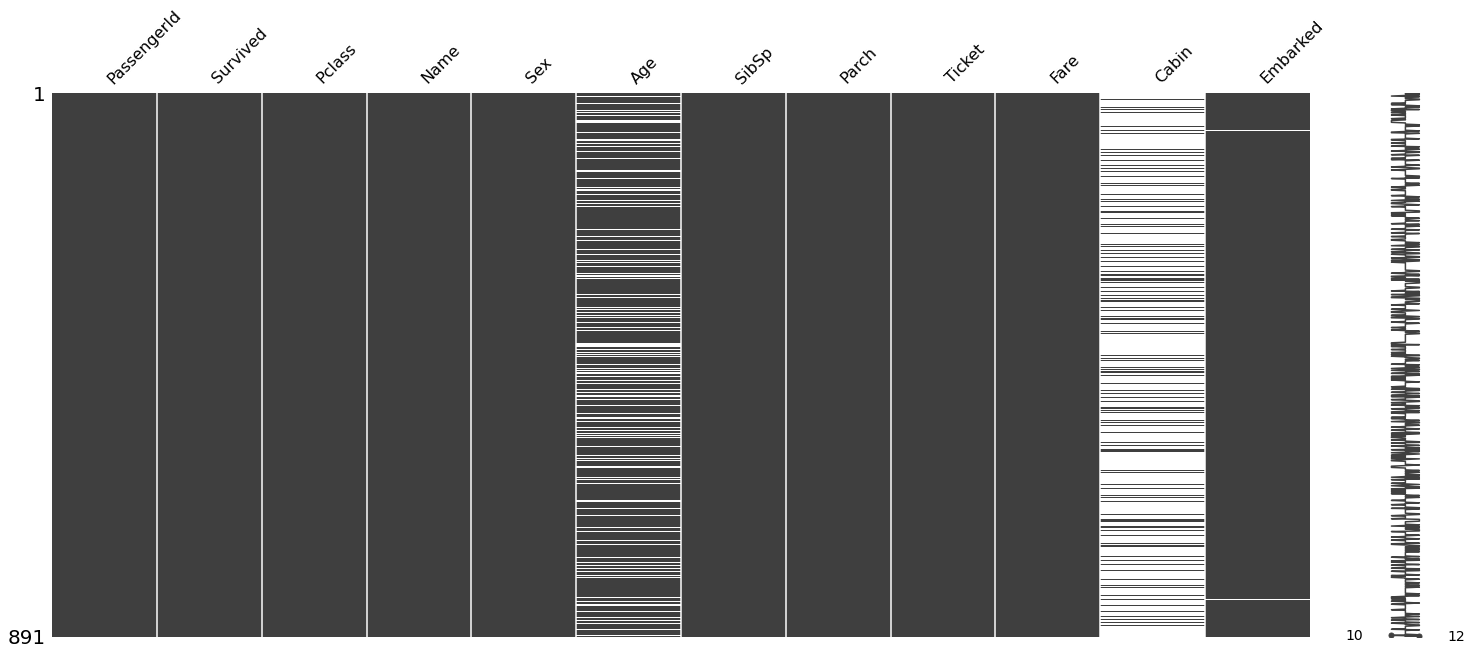

In [11]:
import missingno as msno

msno.matrix(train_data)


### Data Distribution


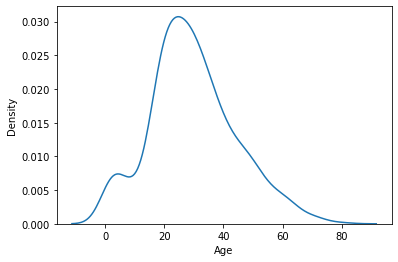

In [13]:
sns.kdeplot(train_data.Age)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


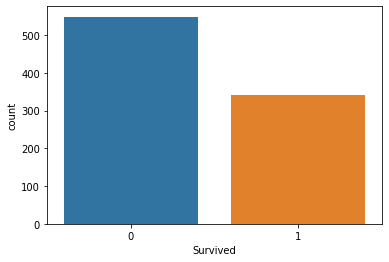

In [15]:
sns.countplot(train_data.Survived)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


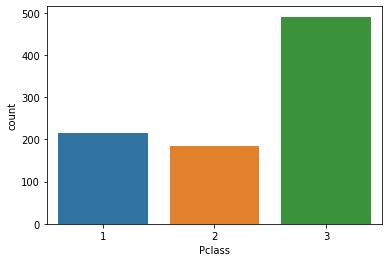

In [16]:
sns.countplot(train_data.Pclass)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


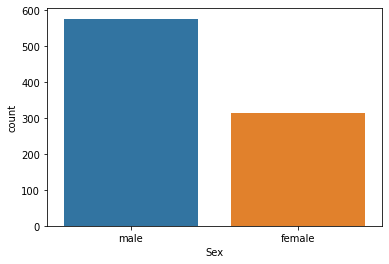

In [17]:
sns.countplot(train_data.Sex)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


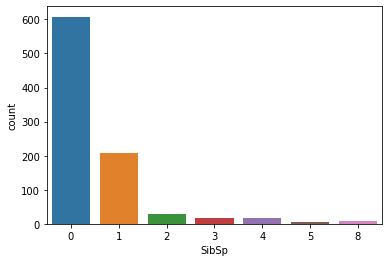

In [18]:
sns.countplot(train_data.SibSp)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


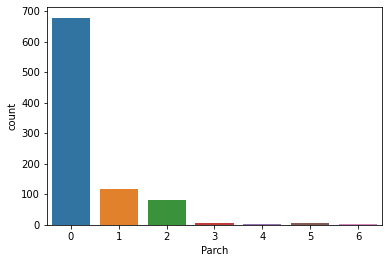

In [19]:
sns.countplot(train_data.Parch)

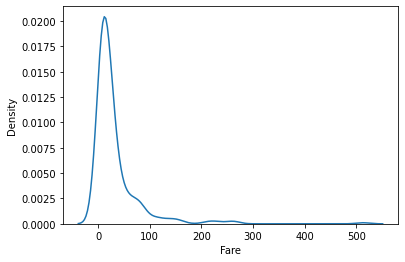

In [20]:
sns.kdeplot(train_data.Fare)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


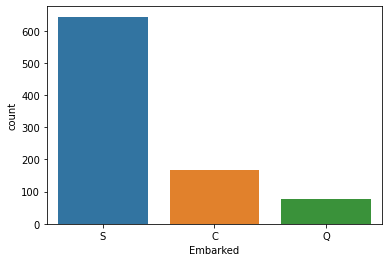

In [21]:
sns.countplot(train_data.Embarked)

In [49]:
train_data["Ticket"].str.extract(r"([a-zA-Z0-9]+)$").nunique()

0    679
dtype: int64

# Data Cleansing

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


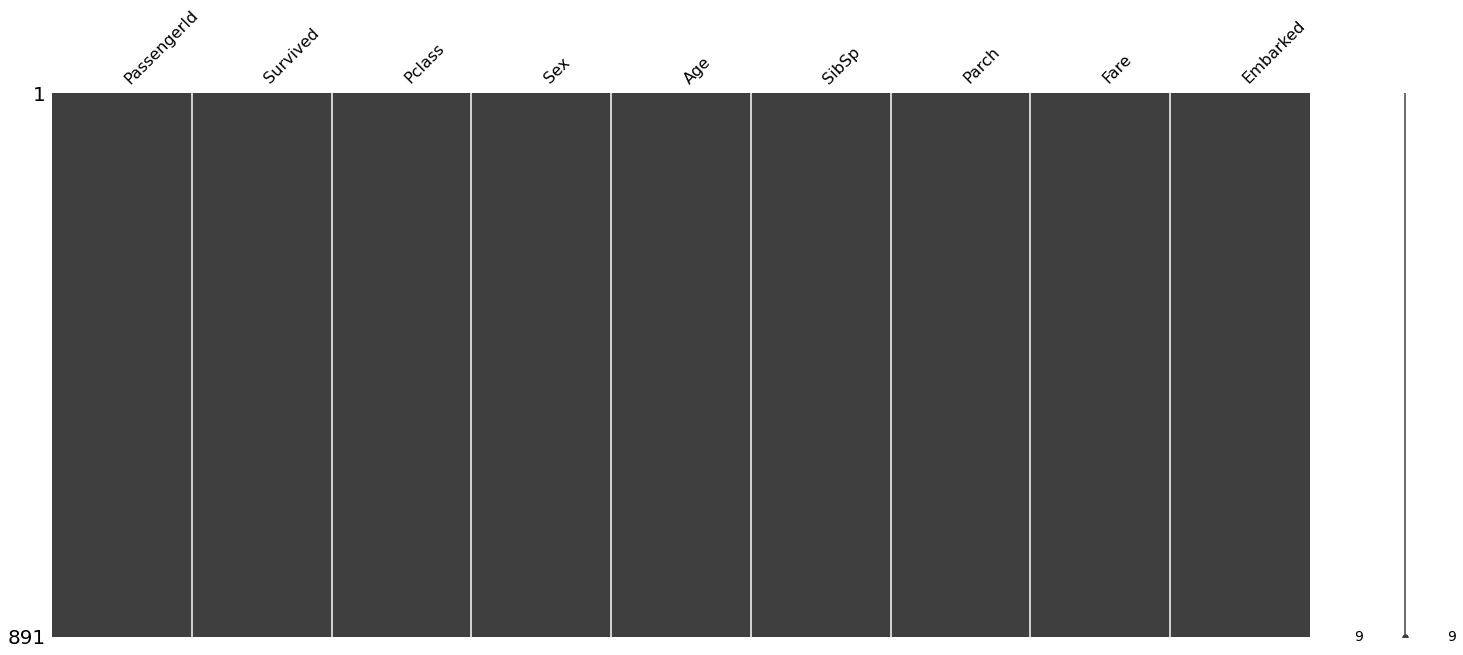

In [55]:
import seaborn as sns
from patsy import dmatrix
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# sns.kdeplot(train["Age"])

# Missing Data: Age, Embarked, Cabin

# remove column which have too many NaN value
cleaned_train_data = train_data.dropna(thresh=int(len(train_data) * 0.5), axis=1)  # Remove Cabin

frequentImputer = SimpleImputer(strategy="most_frequent")
medianImputer = SimpleImputer(strategy="median")

cleaned_train_data.loc[:,"Embarked"] = frequentImputer.fit_transform(cleaned_train_data[["Embarked"]]).copy()
cleaned_train_data.loc[:,"Age"] = medianImputer.fit_transform(cleaned_train_data[["Age"]].copy())

# ["Ticket", "Name"] maybe useless.
cleaned_train_data = cleaned_train_data.drop(["Ticket", "Name"], axis=1)

msno.matrix(cleaned_train_data)

In [ ]:

# 
# scaler = StandardScaler()
# train["Age"] = scaler.fit_transform(cleaned_train_data["Age"].values.reshape(-1, 1))

# train